<a href="https://colab.research.google.com/github/ayberkozcan/image-recognition-pytorch/blob/main/Image_Classification_with_OxfordIIITPet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition using OxfordIIITPet

## Importing Libraries

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading Dataset

In [3]:
train_data = datasets.OxfordIIITPet(
    root="data/train",
    split="trainval",
    transform=ToTensor(),
    download=True
)
test_data = datasets.OxfordIIITPet(
    root="data/test",
    split="test",
    transform=ToTensor(),
    download=True
)

100%|██████████| 792M/792M [00:03<00:00, 217MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 87.0MB/s]
100%|██████████| 792M/792M [00:06<00:00, 122MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 86.1MB/s]


In [4]:
import multiprocessing

print(multiprocessing.cpu_count());

2


## Exploring Dataset

In [5]:
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 3680
Test data length: 3669


There are 3680 training samples and 3669 testing samples in this dataset.

Let's see classes.

In [6]:
class_names = train_data.classes

print(f"Class shape: {len(class_names)}\n")
print(f"Classes:")
for class_name in class_names:
  print(class_name)

Class shape: 37

Classes:
Abyssinian
American Bulldog
American Pit Bull Terrier
Basset Hound
Beagle
Bengal
Birman
Bombay
Boxer
British Shorthair
Chihuahua
Egyptian Mau
English Cocker Spaniel
English Setter
German Shorthaired
Great Pyrenees
Havanese
Japanese Chin
Keeshond
Leonberger
Maine Coon
Miniature Pinscher
Newfoundland
Persian
Pomeranian
Pug
Ragdoll
Russian Blue
Saint Bernard
Samoyed
Scottish Terrier
Shiba Inu
Siamese
Sphynx
Staffordshire Bull Terrier
Wheaten Terrier
Yorkshire Terrier


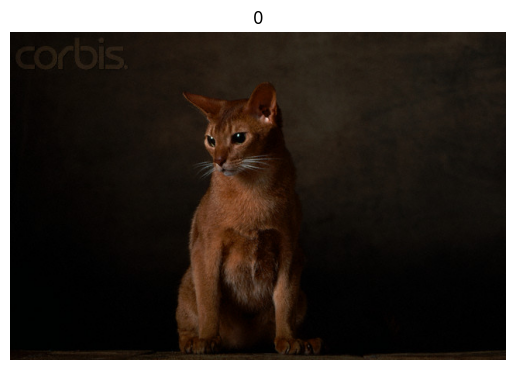

In [7]:
image, label = train_data[15]

plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.axis("Off");

In [8]:
print(f"Image shape: {image.shape}")

Image shape: torch.Size([3, 423, 640])


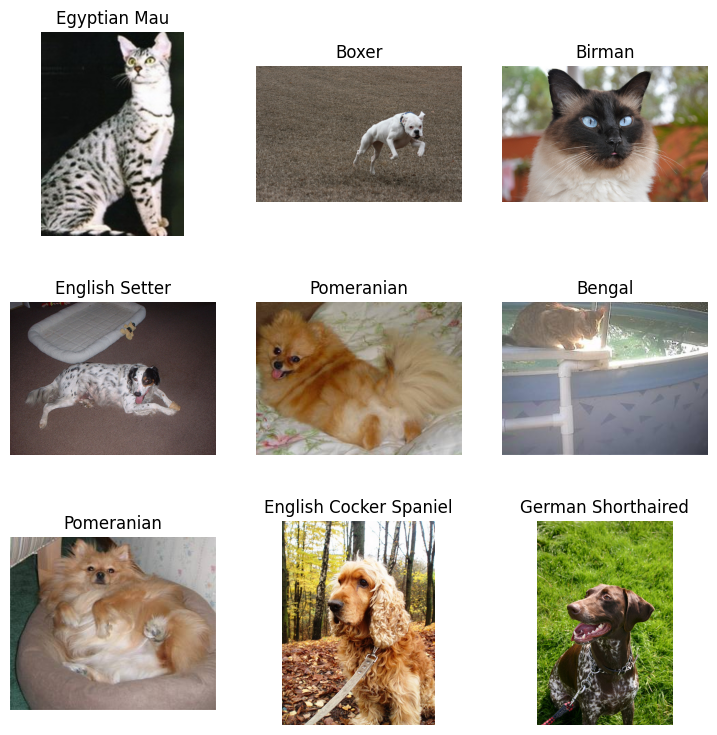

In [9]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
  random_number = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_number]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(class_names[label])
  plt.axis("Off")

plt.show()

## Writing Functions

Let's create a directory to store functions first.

In [10]:
import os

os.makedirs("src", exist_ok=True)

### prepare_data.py

In [11]:
%%writefile src/prepare_data.py

import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

def prepare_data(train_dir, test_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = datasets.OxfordIIITPet(
        root=train_dir,
        split="trainval",
        download=True,
        transform=transform
    )

    test_data = datasets.OxfordIIITPet(
        root=test_dir,
        split="test",
        download=True,
        transform=transform
    )

    print("\n[INFO] Dataset is ready\n")

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=32,
        shuffle=True,
        num_workers=2,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=32,
        shuffle=False,
        num_workers=2
    )

    print("\n[INFO] Dataloaders are ready\n")

    return train_dataloader, test_dataloader, class_names


Writing src/prepare_data.py


### freeze_layers.py

In [12]:
%%writefile src/freeze_layers.py

import torch
import torchvision.models

def freeze_layers(model, class_names, device):
    for param in model.parameters():
        param.requires_grad = False

    if hasattr(model, "features") and hasattr(model, "classifier"):
        # For EfficientNet
        in_shape = model.classifier[1].in_features
        model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=True),
            torch.nn.Linear(in_features=in_shape, out_features=len(class_names), bias=True)
        )

    elif hasattr(model, "fc"):
        # For ResNet
        in_shape = model.fc.in_features
        model.fc = torch.nn.Linear(in_features=in_shape, out_features=len(class_names), bias=True)

    else:
        raise TypeError("Unsupported model type. Only EfficientNet and ResNet are supported.")

    model.to(device)
    return model

Writing src/freeze_layers.py


### train_model.py

In [13]:
%%writefile src/train_model.py

import torch
from torch import nn

def train_model(model, learning_rate, epoch_number, train_dataloader, test_dataloader, device):

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

  def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    return (correct / len(y_true)) * 100

  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  from tqdm.auto import tqdm

  from timeit import default_timer as timer
  train_time_start = timer()

  epochs = epoch_number

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
      X, y = X.to(device), y.to(device)

      model.train()

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss

      train_acc += accuracy_fn(
          y_true=y,
          y_pred=y_pred.argmax(dim=1)
      )

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
      for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_pred = model(X)

        loss = loss_fn(test_pred, y)
        test_loss += loss

        accuracy = accuracy_fn(
            y_true=y, y_pred=test_pred.argmax(dim=1)
        )
        test_acc += accuracy

      test_loss /= len(test_dataloader)
      test_acc /= len(test_dataloader)

    print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  train_time_end = timer()
  total_time = train_time_end - train_time_start

  print(f"Total Time: {total_time} seconds")

  return results, total_time

Writing src/train_model.py


### save_model.py

In [14]:
%%writefile src/save_model.py

import torch
from pathlib import Path

def save_model(model, target_dir, model_name):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(
        parents=True,
        exist_ok=True
    )
    assert model_name.endswith(".pth") or model_name.endswith(".pt")
    model_save_path = target_dir_path / model_name

    print(f"Saving model to: {model_save_path}")
    torch.save(
        obj=model.state_dict(),
        f=model_save_path
    )

Writing src/save_model.py


## Preparing Data

In [15]:
from src import prepare_data

train_dir = "/content/data2/train"
test_dir = "/content/data2/test"

train_dataloader, test_dataloader, class_names = prepare_data.prepare_data(
    train_dir,
    test_dir
)

100%|██████████| 792M/792M [00:05<00:00, 144MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 90.7MB/s]
100%|██████████| 792M/792M [00:07<00:00, 112MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 64.4MB/s]



[INFO] Dataset is ready


[INFO] Dataloaders are ready



## Loading Models (Transfer Learning)

In this chapter, we will use a few PyTorch models. After that, we will freeze their layers and modify their output shapes.

We will use EfficientNetB0, ResNet18 and a custom model.

In [ ]:
# For summary
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### EfficientNetB0

In [16]:
from src import freeze_layers

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

model_eff0 = freeze_layers.freeze_layers(model, class_names, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


In [ ]:
summary(model=model_eff0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### ResNet18

In [17]:
from src import freeze_layers

weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights)

model_resnet = freeze_layers.freeze_layers(model, class_names, device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [ ]:
summary(model=model_resnet,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

### Custom Model

In [ ]:
import torch.nn.functional as F

In [ ]:
class CustomModel(nn.Module):
  def __init__(self, input_shape, hidden_units=64, output_shape=37):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model_custom = CustomModel(
    input_shape= 3 * 224 * 224,
    hidden_units= 64,
    output_shape=len(class_names)
).to(device)

In [ ]:
summary(model=model_custom,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomModel (CustomModel)                [32, 3, 224, 224]    [32, 37]             --                   True
├─Sequential (layer_stack)               [32, 3, 224, 224]    [32, 37]             --                   True
│    └─Flatten (0)                       [32, 3, 224, 224]    [32, 150528]         --                   --
│    └─Linear (1)                        [32, 150528]         [32, 64]             9,633,856            True
│    └─ReLU (2)                          [32, 64]             [32, 64]             --                   --
│    └─Linear (3)                        [32, 64]             [32, 37]             2,405                True
Total params: 9,636,261
Trainable params: 9,636,261
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 308.36
Input size (MB): 19.27
Forward/backward pass size (MB): 0.03
Params size (MB): 38.55
Estimated Total Size (MB): 57.84

Our models are ready. Let's train them now.

## Training

In [18]:
from src import train_model

In [19]:
results_eff0, total_time_eff0 = train_model.train_model(
    model=model_eff0,
    learning_rate=0.001,
    epoch_number=5,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/3680 samples

Train Loss: 2.12509 | Train Accuracy: 58.80%, Test Loss: 1.19807 | Test Accuracy: 78.98%

Epoch: 1
--------
Looked at 0/3680 samples

Train Loss: 0.93677 | Train Accuracy: 83.34%, Test Loss: 0.78771 | Test Accuracy: 83.17%

Epoch: 2
--------
Looked at 0/3680 samples

Train Loss: 0.67099 | Train Accuracy: 86.33%, Test Loss: 0.68174 | Test Accuracy: 83.25%

Epoch: 3
--------
Looked at 0/3680 samples

Train Loss: 0.52214 | Train Accuracy: 89.21%, Test Loss: 0.62876 | Test Accuracy: 83.83%

Epoch: 4
--------
Looked at 0/3680 samples

Train Loss: 0.45841 | Train Accuracy: 90.22%, Test Loss: 0.58420 | Test Accuracy: 84.17%

Total Time: 187.671621586 seconds


In [20]:
results_resnet, total_time_resnet = train_model.train_model(
    model=model_resnet,
    learning_rate=0.001,
    epoch_number=5,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/3680 samples

Train Loss: 1.92794 | Train Accuracy: 56.41%, Test Loss: 0.93900 | Test Accuracy: 81.19%

Epoch: 1
--------
Looked at 0/3680 samples

Train Loss: 0.72719 | Train Accuracy: 85.54%, Test Loss: 0.63597 | Test Accuracy: 84.39%

Epoch: 2
--------
Looked at 0/3680 samples

Train Loss: 0.50590 | Train Accuracy: 88.99%, Test Loss: 0.53907 | Test Accuracy: 85.81%

Epoch: 3
--------
Looked at 0/3680 samples

Train Loss: 0.39732 | Train Accuracy: 91.22%, Test Loss: 0.48280 | Test Accuracy: 86.41%

Epoch: 4
--------
Looked at 0/3680 samples

Train Loss: 0.34327 | Train Accuracy: 92.15%, Test Loss: 0.45602 | Test Accuracy: 87.00%

Total Time: 182.118167718 seconds


In [ ]:
results_custom, total_time_custom = train_model.train_model(
    model=model_custom,
    learning_rate=0.001,
    epoch_number=5,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/3680 samples

Train Loss: 11.99959 | Train Accuracy: 2.96%, Test Loss: 12.07590 | Test Accuracy: 2.93%

Epoch: 1
--------
Looked at 0/3680 samples

Train Loss: 7.76468 | Train Accuracy: 5.98%, Test Loss: 10.97739 | Test Accuracy: 4.10%

Epoch: 2
--------
Looked at 0/3680 samples

Train Loss: 6.69943 | Train Accuracy: 9.65%, Test Loss: 11.28083 | Test Accuracy: 3.37%

Epoch: 3
--------
Looked at 0/3680 samples

Train Loss: 5.60390 | Train Accuracy: 12.28%, Test Loss: 10.25369 | Test Accuracy: 4.39%

Epoch: 4
--------
Looked at 0/3680 samples

Train Loss: 4.74226 | Train Accuracy: 14.86%, Test Loss: 9.89669 | Test Accuracy: 3.97%

Total Time: 177.0885486709999 seconds


Our custom model performed poorly; on the other hand, our other models performed well.

Now, we are going to retrain the EffNetB0 and ResNet18 models with a different learning rate (0.01).

In [21]:
results_eff0_2, total_time_eff0_2 = train_model.train_model(
    model=model_eff0,
    learning_rate=0.01,
    epoch_number=5,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/3680 samples

Train Loss: 0.64512 | Train Accuracy: 80.08%, Test Loss: 0.74285 | Test Accuracy: 78.52%

Epoch: 1
--------
Looked at 0/3680 samples

Train Loss: 0.33656 | Train Accuracy: 88.99%, Test Loss: 0.74986 | Test Accuracy: 80.35%

Epoch: 2
--------
Looked at 0/3680 samples

Train Loss: 0.29183 | Train Accuracy: 90.76%, Test Loss: 0.83384 | Test Accuracy: 78.86%

Epoch: 3
--------
Looked at 0/3680 samples

Train Loss: 0.24547 | Train Accuracy: 92.23%, Test Loss: 0.85747 | Test Accuracy: 80.09%

Epoch: 4
--------
Looked at 0/3680 samples

Train Loss: 0.23959 | Train Accuracy: 92.64%, Test Loss: 0.92568 | Test Accuracy: 79.54%

Total Time: 182.787746105 seconds


In [22]:
results_resnet_2, total_time_resnet_2 = train_model.train_model(
    model=model_resnet,
    learning_rate=0.01,
    epoch_number=5,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/3680 samples

Train Loss: 0.80145 | Train Accuracy: 78.18%, Test Loss: 0.63972 | Test Accuracy: 81.86%

Epoch: 1
--------
Looked at 0/3680 samples

Train Loss: 0.42186 | Train Accuracy: 87.15%, Test Loss: 0.69030 | Test Accuracy: 82.01%

Epoch: 2
--------
Looked at 0/3680 samples

Train Loss: 0.34938 | Train Accuracy: 88.75%, Test Loss: 1.26386 | Test Accuracy: 74.80%

Epoch: 3
--------
Looked at 0/3680 samples

Train Loss: 0.45532 | Train Accuracy: 88.45%, Test Loss: 1.10385 | Test Accuracy: 79.55%

Epoch: 4
--------
Looked at 0/3680 samples

Train Loss: 0.34543 | Train Accuracy: 90.33%, Test Loss: 0.86780 | Test Accuracy: 82.63%

Total Time: 180.23838393899996 seconds


In [23]:
# Example
print(results_resnet_2)

{'train_loss': [0.8014482259750366, 0.4218589961528778, 0.349383682012558, 0.4553189277648926, 0.34543153643608093], 'train_acc': [78.17934782608695, 87.14673913043478, 88.75, 88.45108695652173, 90.32608695652173], 'test_loss': [0.6397157311439514, 0.6903002858161926, 1.2638605833053589, 1.1038509607315063, 0.8677951693534851], 'test_acc': [81.86076604554866, 82.00957556935818, 74.80331262939958, 79.54968944099379, 82.63457556935818]}


In [24]:
formatted_results_eff0 = {}

formatted_results_eff0["model_name"] = "EfficientNetB0"
formatted_results_eff0["total_time"] = total_time_eff0
for key, value in results_eff0.items():
  formatted_results_eff0[key] = value[-1]


formatted_results_resnet = {}

formatted_results_resnet["model_name"] = "ResNet18"
formatted_results_resnet["total_time"] = total_time_resnet
for key, value in results_resnet.items():
  formatted_results_resnet[key] = value[-1]


formatted_results_eff0_2 = {}

formatted_results_eff0_2["model_name"] = "EfficientNetB0_2"
formatted_results_eff0_2["total_time"] = total_time_eff0_2
for key, value in results_eff0_2.items():
  formatted_results_eff0_2[key] = value[-1]


formatted_results_resnet_2 = {}

formatted_results_resnet_2["model_name"] = "ResNet18_2"
formatted_results_resnet_2["total_time"] = total_time_resnet_2
for key, value in results_resnet_2.items():
  formatted_results_resnet_2[key] = value[-1]

In [25]:
# Example
formatted_results_resnet_2

{'model_name': 'ResNet18_2',
 'total_time': 180.23838393899996,
 'train_loss': 0.34543153643608093,
 'train_acc': 90.32608695652173,
 'test_loss': 0.8677951693534851,
 'test_acc': 82.63457556935818}

In [26]:
import pandas as pd

formatted_results = [
    formatted_results_eff0,
    formatted_results_resnet,
    formatted_results_eff0_2,
    formatted_results_resnet_2
]

df = pd.DataFrame(formatted_results)

In [27]:
df['train_acc'] = df['train_acc'].apply(lambda x: f"{x:.2f}%")
df['test_acc'] = df['test_acc'].apply(lambda x: f"{x:.2f}%")

In [28]:
df

,model_name,total_time,train_loss,train_acc,test_loss,test_acc
0,EfficientNetB0,187.671622,0.458415,90.22%,0.584197,84.17%
1,ResNet18,182.118168,0.343272,92.15%,0.456022,87.00%
2,EfficientNetB0_2,182.787746,0.239589,92.64%,0.925678,79.54%
3,ResNet18_2,180.238384,0.345432,90.33%,0.867795,82.63%


Our dataframe shows that it would be better to use the ResNet18 model with the best accuracy.

## Evaluation

### Loss and Accuracy Plots

In [40]:
loss = results_resnet['train_loss']
test_loss = results_resnet['test_loss']

accuracy = results_resnet['train_acc']
test_accuracy = results_resnet['test_acc']

epochs = range(len(results_resnet['train_loss']))

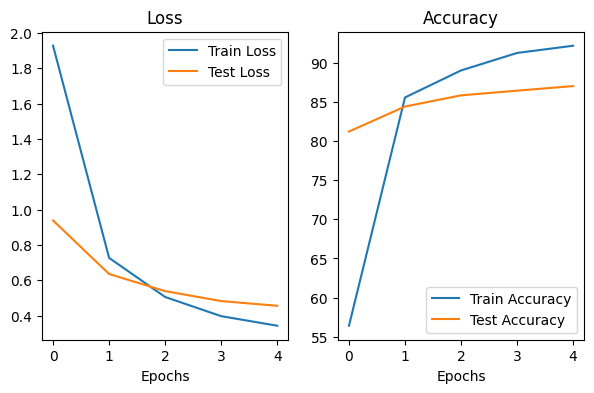

In [41]:
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="Train Accuracy")
plt.plot(epochs, test_accuracy, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

### Confusion Matrix

In [43]:
from tqdm.auto import tqdm

y_preds = []

model_resnet.to(device)

model_resnet.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_resnet(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred)

  y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/115 [00:00<?, ?it/s]

In [44]:
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print("Installation done!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.6 MB/s eta 0:00:00
Installation done!


In [45]:
print(f"torchmetrics version: {torchmetrics.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

torchmetrics version: 1.6.3
mlxtend version: 0.23.4


In [46]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

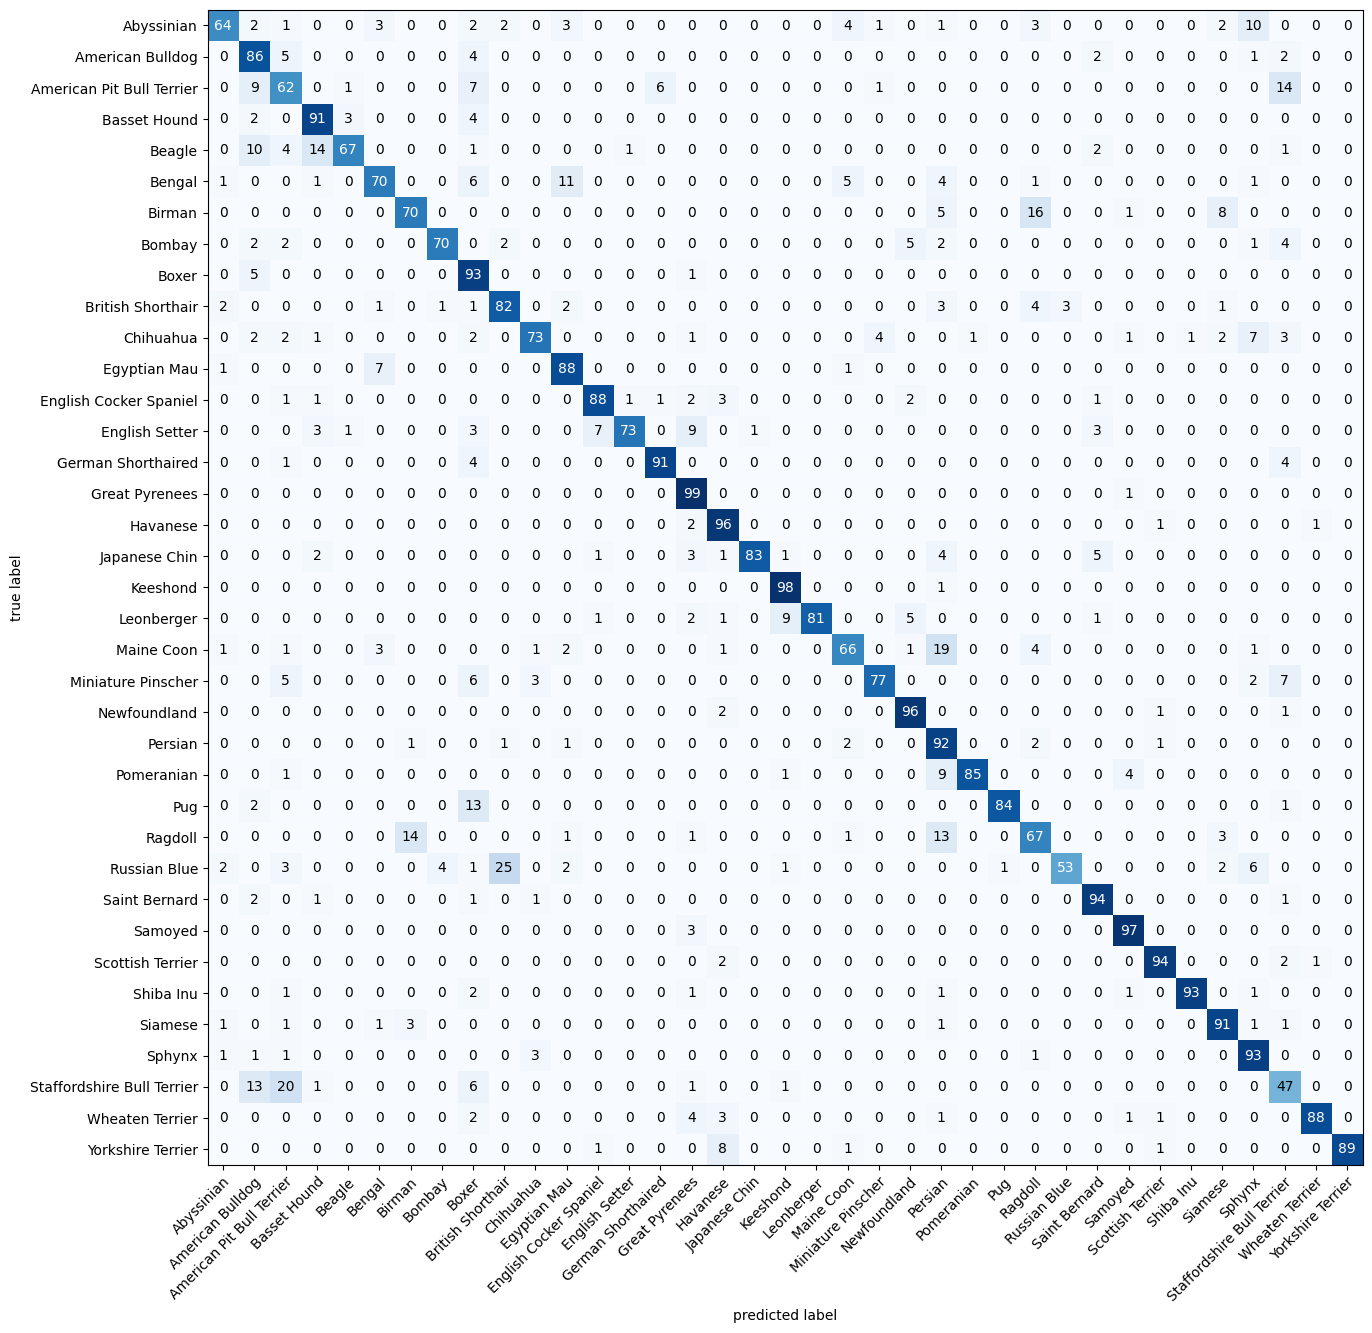

In [54]:
confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass"
).to(device)
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=torch.tensor([label for _, label in test_data]).to(device)
)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(15, 15)
);

## Making Predictions

In [129]:
beagle_path = "images_to_pred/beagle.jpg"
chihuahua_path = "images_to_pred/chihuahua.jpg"
newfoundland_path = "images_to_pred/newfoundland.jpg"
ragdoll_path = "images_to_pred/ragdoll.jpg"
spaniel_path = "images_to_pred/spaniel.jpg"

image_paths = [beagle_path, chihuahua_path, newfoundland_path, ragdoll_path, spaniel_path]

In [130]:
images = []

for image_path in image_paths:
  image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  image /= 255
  images.append(image)

In [131]:
print(f"Image tensor:\n{images[0]}")
print(f"Image shape: {images[0].shape}")

Image tensor:
tensor([[[0.4157, 0.3529, 0.3373,  ..., 0.7608, 0.7608, 0.7608],
         [0.3608, 0.3686, 0.3843,  ..., 0.7608, 0.7608, 0.7608],
         [0.3373, 0.3569, 0.3451,  ..., 0.7608, 0.7608, 0.7608],
         ...,
         [0.5176, 0.4902, 0.4353,  ..., 0.4314, 0.4196, 0.4196],
         [0.4824, 0.4863, 0.3843,  ..., 0.4314, 0.4196, 0.4196],
         [0.3529, 0.4471, 0.3176,  ..., 0.4314, 0.4196, 0.4196]],

        [[0.4627, 0.4000, 0.3843,  ..., 0.7255, 0.7255, 0.7255],
         [0.4078, 0.4157, 0.4314,  ..., 0.7255, 0.7255, 0.7255],
         [0.3843, 0.4039, 0.3922,  ..., 0.7255, 0.7255, 0.7255],
         ...,
         [0.5412, 0.5137, 0.4588,  ..., 0.5569, 0.5529, 0.5529],
         [0.5059, 0.5098, 0.4078,  ..., 0.5569, 0.5529, 0.5529],
         [0.3765, 0.4706, 0.3412,  ..., 0.5569, 0.5529, 0.5529]],

        [[0.4549, 0.3922, 0.3765,  ..., 0.2510, 0.2510, 0.2510],
         [0.4000, 0.4078, 0.4235,  ..., 0.2510, 0.2510, 0.2510],
         [0.3765, 0.3961, 0.3843,  ..., 0.25

Let's see one of our images.

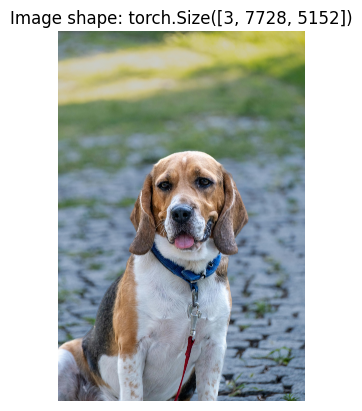

In [132]:
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Image shape: {images[0].shape}")
plt.axis(False);

In [133]:
print(f"Custom image shape: {images[0].shape}")
print(f"Image in dataset shape: {image.shape}")

Custom image shape: torch.Size([3, 7728, 5152])
Image in dataset shape: torch.Size([3, 3111, 3889])


In [134]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

resized_images = []
for image in images:
  resized_image = image_transform(image)
  resized_images.append(resized_image)

In [135]:
print(f"Original shape: {images[0].shape}\n")
print(f"Transformed shape: {resized_images[0].shape}")
print(f"Image in dataset shape: {train_data[0][0].shape}")

Original shape: torch.Size([3, 7728, 5152])

Transformed shape: torch.Size([3, 224, 224])
Image in dataset shape: torch.Size([3, 500, 394])


Let's see our resized image.

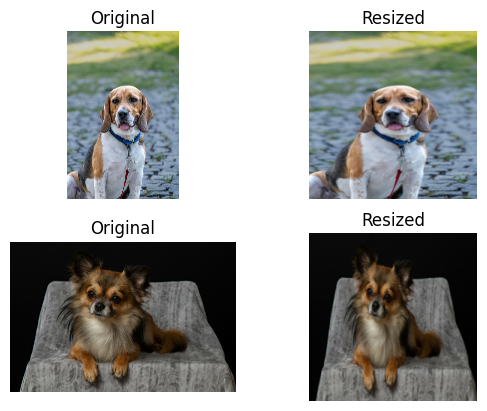

In [136]:
plt.subplot(2, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))
plt.title("Original")
plt.axis(False)

plt.subplot(2, 2, 2)
plt.imshow(resized_images[0].permute(1, 2, 0))
plt.title("Resized")
plt.axis(False);

plt.subplot(2, 2, 3)
plt.imshow(images[1].permute(1, 2, 0))
plt.title("Original")
plt.axis(False)

plt.subplot(2, 2, 4)
plt.imshow(resized_images[1].permute(1, 2, 0))
plt.title("Resized")
plt.axis(False);

In [137]:
model_resnet.eval()
predictions = []

with torch.inference_mode():
  for image in resized_images:
    image = image.unsqueeze(dim=0).to(device)
    pred = model_resnet(image)
    predictions.append(pred)

In [138]:
predictions[0]

tensor([[-14.2023,  -3.0683,  -6.5708,  -2.1951,   2.4150, -18.5104, -18.9335,
         -26.8777, -10.6420, -22.2414, -15.5902, -13.7337,  -5.6546,  -6.0980,
           2.6709,  -8.1130, -14.4577, -20.5809, -18.5109, -16.0791, -19.2711,
         -14.0601, -12.3319, -20.5403, -23.4359, -15.0411, -16.0247, -14.3095,
          -9.8530, -20.5871, -23.2255, -20.8355, -24.0877, -14.8035, -13.2249,
         -11.9332, -12.1944]], device='cuda:0')

In [139]:
prediction_labels = []

for prediction in predictions:
  pred_probs = torch.softmax(prediction, dim=1)
  pred_label = torch.argmax(pred_probs, dim=1)
  prediction_labels.append(pred_label)

In [140]:
prediction_labels

[tensor([14], device='cuda:0'),
 tensor([24], device='cuda:0'),
 tensor([22], device='cuda:0'),
 tensor([26], device='cuda:0'),
 tensor([12], device='cuda:0')]

In [141]:
predicted_classes = []

for label in prediction_labels:
  predicted_class = class_names[label]
  predicted_classes.append(predicted_class)

In [142]:
predicted_classes

['German Shorthaired',
 'Pomeranian',
 'Newfoundland',
 'Ragdoll',
 'English Cocker Spaniel']